Configuração Inicial e Carregamento das Previsões

In [28]:
# Imports necessários
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Inicialização da sessão Spark
spark = SparkSession\
        .builder\
        .appName("Projeto_AJP")\
        .master("local[*]")\
        .config("spark.executor.memory", "8g")\
        .config("spark.driver.memory", "8g")\
        .config("spark.driver.maxResultSize", "1g")\
        .config("spark.memory.offHeap.enabled", False)\
        .enableHiveSupport()\
        .getOrCreate()

In [29]:
# Função para carregar previsões e convertê-las para pandas DataFrame
def load_predictions(path):
    df = spark.read.parquet(path)
    return df.select("IsDelayed", "prediction", "probability").toPandas()

# Carregar previsões
lr_predictions = load_predictions("../data/predictions/lr_predictions.parquet")
dt_predictions = load_predictions("../data/predictions/dt_predictions.parquet")
rf_predictions = load_predictions("../data/predictions/rf_predictions.parquet")

Definir Funções para os Gráficos

In [30]:
# Função para calcular a matriz de confusão
def plot_confusion_matrix(df, model_name):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(df['IsDelayed'], df['prediction'])

    # Calcular a matriz de confusão em termos de porcentagem
    cm_percentage = cm.astype('float') / cm.sum() * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Not Delayed", "Delayed"])
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title(f'Confusion Matrix - {model_name} - %')
    plt.show()

# Função para calcular e plotar a curva ROC
def plot_roc_curve(df, model_name):
    from sklearn.metrics import roc_curve, auc

    y_true = df['IsDelayed']
    y_scores = df['probability'].apply(lambda x: x[1])  # Probabilidade da classe 1
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Função para calcular e plotar métricas
def plot_metrics(metrics, model_name):
    metrics_df = pd.DataFrame([metrics], columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score'])
    metrics_df['Model'] = model_name

    metrics_df = pd.melt(metrics_df, id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Score', y='Metric', data=metrics_df, palette='viridis')
    plt.title(f'Model Performance Metrics - {model_name}')
    plt.xlabel('Score')
    plt.ylabel('Metric')
    plt.legend(loc='best')
    plt.show()

Regressão Logística

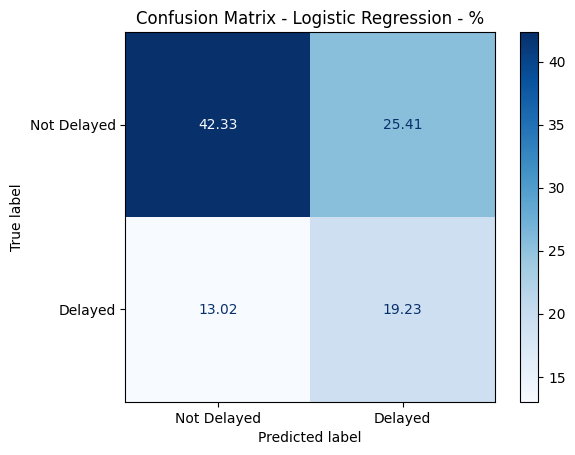

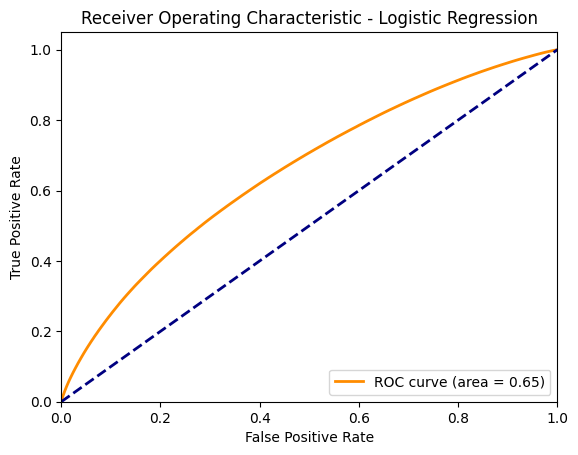

In [31]:
plot_confusion_matrix(lr_predictions, 'Logistic Regression')
plot_roc_curve(lr_predictions, 'Logistic Regression')

Árvore de Decisão

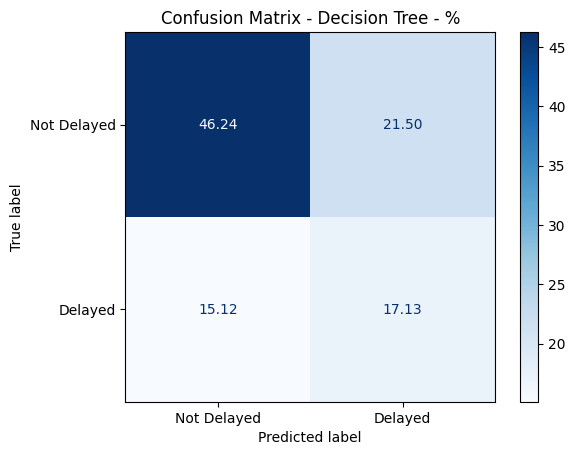

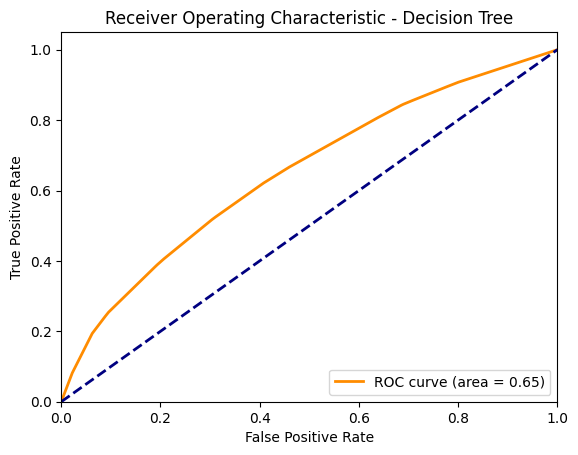

In [32]:
plot_confusion_matrix(dt_predictions, 'Decision Tree')
plot_roc_curve(dt_predictions, 'Decision Tree')

Random Forest

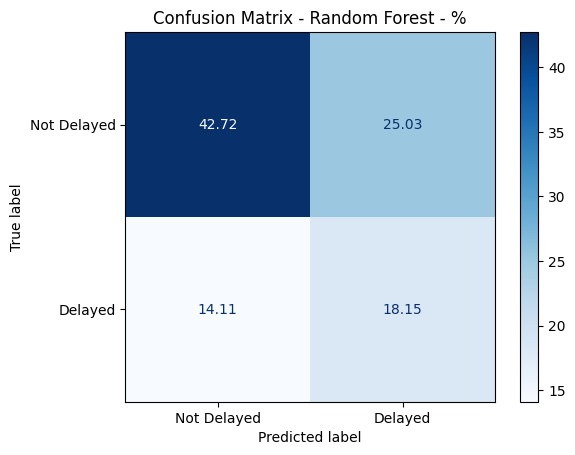

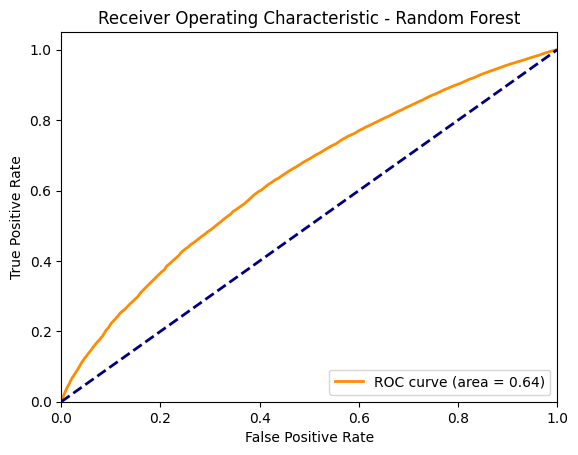

In [33]:
plot_confusion_matrix(rf_predictions, 'Random Forest')
plot_roc_curve(rf_predictions, 'Random Forest')

Encerrar Spark

In [34]:
# Encerrar a sessão Spark
spark.stop()